In [ ]:
!git clone https://github.com/stvschmdt/ne_ds5230.git

fatal: destination path 'ne_ds5230' already exists and is not an empty directory.


In [ ]:
%cd ne_ds5230/prep_material

/content/ne_ds5230/prep_material


# Hierarchical clustering

<b>Hierarchical clustering </b> (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:

- <b>Agglomerative </b>: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
- <b>Divisive </b>: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

In general, the merges and splits are determined in a greedy manner. The results of hierarchical clustering are usually presented in a dendrogram.

## Agglomerative Clustering

Initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until 1/ K clusters are formed.

The main advantage is that we don’t need to specify the number of clusters, this comes with a price: performance $O(n^3)$. In sklearn’s implementation, we can specify the number of clusters to assist the algorithm’s performance.

### Algorithm
- Compute the proximity matrix
- Let each data point be a cluster
- Repeat: Merge two closest clusters and update the proximity matrix until 1/ K cluster remains

Ex. - We have six data points {A,B,C,D,E,F}.

- In the initial step, we consider all the six data points as individual clusters as shown in the image below.

![Figure 1](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/agglomerative_clustering_fig1.png?raw=1)

- The first step is to determine which elements to merge in a cluster. Usually, we want to take the two closest elements, according to the chosen distance.We construct a distance matrix at this stage, where the number in the i-th row j-th column is the distance between the i-th and j-th elements. Then, as clustering progresses, rows and columns are merged as the clusters are merged and the distances updated.

#### Computation of proximity/distance matrix

The choice of an appropriate metric will influence the shape of the clusters, as some elements may be close to one another according to one distance and farther away according to another. For example, in a 2-dimensional space, the distance between the point (1,0) and the origin (0,0) is always 1 according to the usual norms, but the distance between the point (1,1) and the origin (0,0) can be 2 under Manhattan distance, $\sqrt2$ under Euclidean distance, or 1 under maximum distance.

Some commonly used metrics for hierarchical clustering are:

![Table 1](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/agglomerative_clustering_tab1.png?raw=1)

For text or other non-numeric data, metrics such as the Hamming distance or Levenshtein distance are often used.

- Similar clusters are merged together and formed as a single cluster. Let’s consider B,C, and D,E are similar clusters that are merged in step two. Now, we’re left with four clusters which are A, BC, DE, F. To calculate the proximity between two clusters, we need to define the distance between them. Usually the distance is one of the following:
     - The maximum distance between elements of each cluster (also called  <b> complete-linkage clustering </b>)
     - The minimum distance between elements of each cluster (also called <b> single-linkage clustering </b>)
     - The mean distance between elements of each cluster (also called <b> average linkage clustering </b>)
     - The sum of all intra-cluster variance.
- Again calculate the proximity of new clusters and merge the similar clusters to form new clusters A, BC, DEF.
- Calculate the proximity of the new clusters. The clusters DEF and BC are similar and merged together to form a new cluster. We’re now left with two clusters A, BCDEF.
- Finally, all the clusters are merged together and form a single cluster.



The Hierarchical clustering Technique can be visualized using a Dendrogram.
A Dendrogram is a tree-like diagram that records the sequences of merges or splits.

![Figure 2](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/agglomerative_clustering_fig2.png?raw=1)

### Example


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [ ]:
raw_df = pd.read_csv('CC GENERAL.csv')
raw_df = raw_df.drop('CUST_ID', axis = 1)
raw_df.fillna(method ='ffill', inplace = True)
raw_df.head(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12


In [ ]:
# Standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(raw_df)

# Normalizing the Data
normalized_df = normalize(scaled_df)

# Converting the numpy array into a pandas DataFrame
normalized_df = pd.DataFrame(normalized_df)

# Reducing the dimensions of the data
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(normalized_df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

X_principal.head(2)

,P1,P2
0,-0.489949,-0.679977
1,-0.519099,0.544825


<b>Dendograms </b> are used to divide a given cluster into many different clusters.

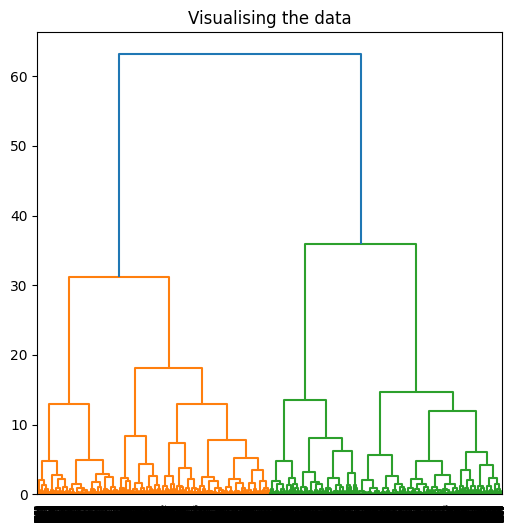

In [ ]:
plt.figure(figsize =(6, 6))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

Determine the optimal number of clusters using <b> [Silhouette Score](https://www.kaggle.com/vipulgandhi/kmeans-detailed-explanation)</b> - the mean Silhouette Coefficient for all samples.

**Silhouette Coefficient:** calculated with the mean intra-cluster distance and mean nearest-cluster distance for each sample

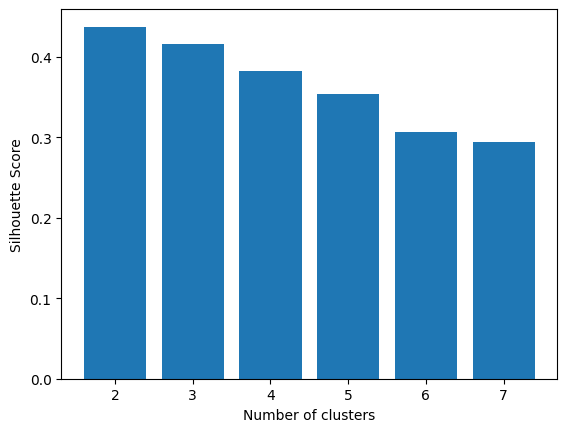

In [ ]:
silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append(
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(X_principal)))

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6,7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 10)
plt.ylabel('Silhouette Score', fontsize = 10)
plt.show()

Building and Visualizing clustering model for k = 3

In [ ]:
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(X_principal)

AgglomerativeClustering(n_clusters=3)

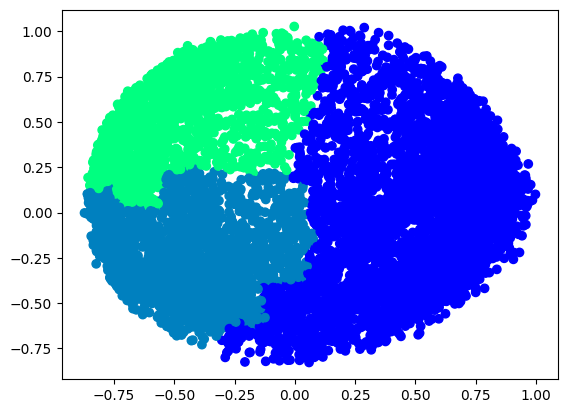

In [ ]:
# Visualizing the clustering
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = AgglomerativeClustering(n_clusters = 3).fit_predict(X_principal), cmap =plt.cm.winter)
plt.show()

# K-Means Clustering


Agglomerative clustering isn't the only type of cluster analysis available to us! A popular method clustering is called **k-means** clustering, where given a specified number of clusters, we iterate through each data point and choose which cluster to assign the point to based on its nearest *centroid*.

**Centroid** - A centroid is a data point at the center of a cluster. In centroid-based clustering, clusters are represented by a centroid. It is an iterative algorithm in which the notion of similarity is derived by how close a data point is to the centroid of the cluster.

## How the algorithm works
The k-means algorithm starts with initial estimates for the K centroids. The algorithm then iterates between two steps:

1. **Data assignment step**: Each centroid defines one of the clusters. In this step, each data point is assigned to its nearest centroid, which is based on the squared Euclidean distance. So, if ci is the collection of centroids in set C, then each data point is assigned to a cluster based on minimum Euclidean distance.

2. **Centroid update step**: In this step, the centroids are recomputed and updated. This is done by taking the mean of all data points assigned to that centroid's cluster.

The algorithm then iterates between step 1 and step 2 until a stopping criteria is met. Stopping criteria means no data points change the clusters, the sum of the distances is minimized or some maximum number of iterations is reached. This algorithm is guaranteed to converge to a result. The result may be a local optimum meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.


![Figure 1](https://github.com/stvschmdt/ne_ds5230/blob/main/prep_material/kmeans_fig1.png?raw=1)

To determine the optimal number of clusters for k-means, we can again use the **silhouette coefficient**.

In [ ]:
silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append(
        silhouette_score(X_principal, KMeans(n_clusters = n_cluster).fit_predict(X_principal)))

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6,7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 10)
plt.ylabel('Silhouette Score', fontsize = 10)
plt.show()